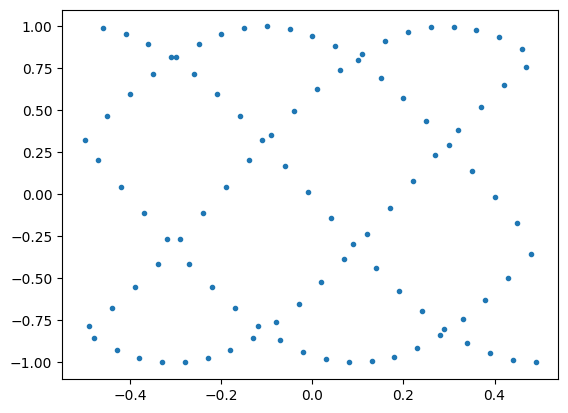

In [14]:
plt.plot(t, x, '.')

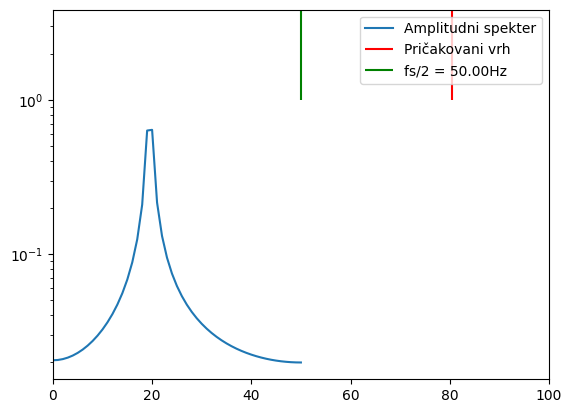

In [12]:
import matplotlib.pyplot as plt
import numpy as np

f = 80.5 # <<<<<<<<<<<<<<<<
T = 1.
N = 100
t, dt = np.linspace(-T/2, T/2, N, endpoint=False, retstep=True)
fs = 1/dt
x = np.cos(2*f*np.pi*t+0.33)

X1=np.fft.rfft(x)*2/len(x)

f1=np.fft.rfftfreq(len(x),dt)
plt.semilogy(f1, np.abs(X1), label='Amplitudni spekter');
plt.vlines(f, 1, 1000, 'r', label='Pričakovani vrh')
plt.vlines(fs/2, 1, 1000, 'g', label=f'fs/2 = {fs/2:3.2f}Hz')
plt.xlim(0, fs/2+50)
plt.legend();

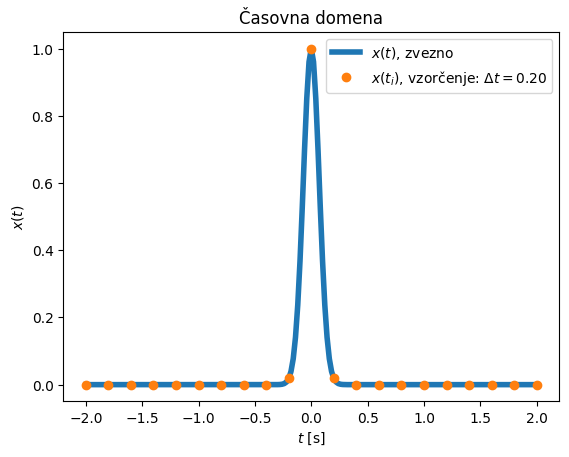

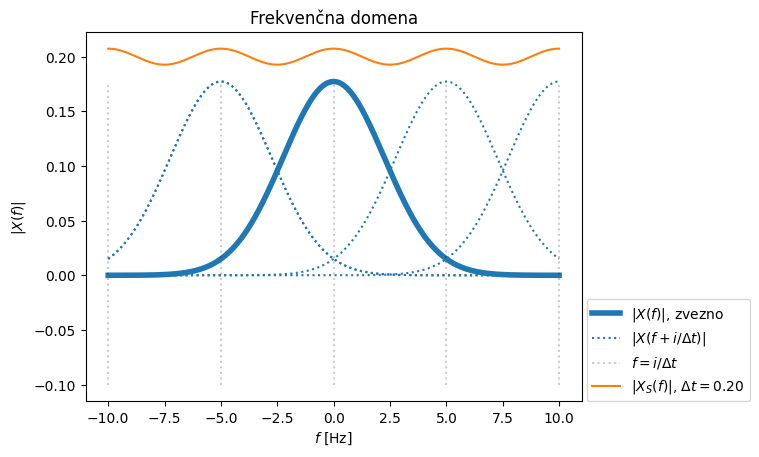

In [17]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np

# navodilo: spreminaj parameter `a`

t, f = sym.symbols('t, f', real=True)
n, Δt = sym.symbols('n, Δt')
a = sym.symbols('a', real=True, positive=True)
x = sym.exp(-a*t**2)
X = sym.fourier_transform(x, t, f)
Xsum = sym.Sum(X.subs(f, f-n/Δt), (n, -10, 10))

podatki = {a: 100, Δt: .2}
# pripravimo vektorizirane funkcije za numpy
f_x = sym.lambdify(t, x.subs(podatki), 'numpy')
f_X_abs = sym.lambdify(f, sym.Abs(X.subs(podatki)), 'numpy')
f_Xsum_abs = sym.lambdify(f, sym.Abs(Xsum.subs(podatki)), 'numpy')

# zaloga vrednosti v času in frekvenci (t_g so 'gosti' podatki za prikaz zvezne funkcije)
N = int(2/podatki[Δt]) # približno število -N, da imamo časovni trak cca [-2,2]
t_g = np.arange(-10*N,10*N+1)*podatki[Δt]/10
n = np.arange(-N,N+1)
t_i = n*podatki[Δt]
K = 2 # koliko sosednijih preslikav X(f) prikažemo
fr = np.linspace(-K/podatki[Δt],K/podatki[Δt], num=500)

plt.title('Časovna domena')
plt.plot(t_g, f_x(t_g), 'C0', label='$x(t)$, zvezno', linewidth=4)
plt.plot(t_i, f_x(t_i), color='C1', marker='o', ls='', label=f'$x(t_i)$, vzorčenje: $\\Delta t=${podatki[Δt]:3.2f}')
plt.xlabel('$t$ [s]')
plt.ylabel('$x(t)$')
plt.legend()
plt.show()

plt.title('Frekvenčna domena')
plt.plot(fr, f_X_abs(fr), 'C0', label='$|X(f)|$, zvezno', linewidth=4)
for i in range(-K,K):
    plt.plot(fr, f_X_abs(fr+i/podatki[Δt]), 'C0', ls=':')
    plt.vlines(i/podatki[Δt], -0.1, np.max(f_X_abs(fr)), 'k', ls=':', alpha=0.2)
plt.plot(fr, f_X_abs(fr+i/podatki[Δt]), 'C0', ls=':', label='$|X(f+i/\\Delta t)|$')
plt.vlines((i+1)/podatki[Δt], -0.1, np.max(f_X_abs(fr)), 'k', ls=':', alpha=0.2, label='$f=i/\\Delta t$')
plt.plot(fr, f_Xsum_abs(fr), color='C1', label=f'$|X_S(f)|$, $\\Delta t=${podatki[Δt]:3.2f}')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$|X(f)|$')
plt.legend(loc=(1.01,0))
plt.show()